In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.stattools import acf
import missingno as msno

In [124]:
def load_data():
    df = pd.read_csv('../data/ywan1077/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    # df = pd.read_csv('/users/ywan1077/data/yye45/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [125]:
def xgboost_pipeline(df):
    """
    XGBoost Feature Engineering Pipeline

    This pipeline performs minimal cleaning and targeted feature engineering
    to prepare the dataset for XGBoost modeling. Specifically, it:

    - Drops irrelevant or identifier columns that are not useful for prediction
    - Extracts temporal features (quarter, week) from the deposit date
    - Creates ratio-based and volatility-based transaction features
    - Creates frequency-based features from historical transaction dates
    - Creates behavioral flags based on deposit amount anomalies
    - Processes bucketed and binary categorical features into numeric form
    - Preserves missing values (np.nan) without imputation
    - Does not perform feature scaling or one-hot encoding
    - Leaves outlier values as-is without clipping

    The resulting dataset is fully numeric, with missing values retained, and ready for XGBoost models.
    """

    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
        # 'return_target'  # 👈 加上这行！
    ]

    df = df.drop(columns=cols_to_drop, errors='ignore')

    # --------------- process deposit_dt columns --------------- 
    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'], errors='coerce')
    df['fe_deposit_quarter'] = df['deposit_dt'].dt.quarter
    df['fe_deposit_week'] = df['deposit_dt'].dt.isocalendar().week
    df = df.drop(columns=['deposit_dt'])


    # --------------- process item_amt, total_deposit_amount, relationship_balance columns --------------- 
    ## Ratio of current deposit item amount to total deposit amount, large single deposits are potentially unusual 如果一笔交易占今天总交易很大一部分会不会是诈骗
    epsilon = 1e-6
    denom_balance = df['relationship_balance']
    denom_balance = np.where(denom_balance <= 0, epsilon, denom_balance)

    df['fe_amt_ratio_to_total'] = df['item_amt'] / (df['total_deposit_amount'] + 1)
    ## Ratio of current deposit item amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果一笔交易占用户总余额很大一部分会不会是诈骗
    df['fe_amt_ratio_to_balance'] = (df['item_amt'] / denom_balance).clip(upper=1e6)
    ## Ratio of total deposit amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果今天的总交易占用户总余额很大一部分会不会是诈骗
    df['fe_total_amt_ratio_to_balance'] = (df['total_deposit_amount'] / denom_balance).clip(upper=1e6)
    ## Difference between current deposit amount and previous transaction amount, abnormal fluctuations 如果这笔交易比上一笔变化很多会不会是诈骗
    df['fe_amt_change_from_prev'] = df['item_amt'] - df['prevtran1']
    ## Flag indicating whether the current deposit item is 1.5x larger than the past 30-day maximum deposit, Is it significantly higher than the largest deposit in the last 30 days 如果一笔交易是这一个月的最大交易会不会是诈骗
    df['fe_high_amt_flag'] = (df['item_amt'] > (df['max_deposit_amount30d'] * 1.5)).astype(int)
    ## Ratio of maximum single deposit amount in past 30 days to the total deposit amount 
    df['fe_max30d_ratio_total'] = df['max_deposit_amount30d'] / (df['total_deposit_amount'] + 1)
        
    # --------------- process rdis columns --------------- 
    ## fill NA as 0 to rdis
    df['rdis'] = df['rdis'].fillna(0)
    df['fe_rdis_flag'] = (df['rdis'] > 0).astype(int)

    # --------------- process prevtrandate columns --------------- 
    ## process prevtrandate to capture short-term transaction frequency.
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    # Create transaction count features
    ## Number of transactions within 1 day
    df['fe_num_trans_in_1d'] = (df[prevtrandate_cols] <= 1).sum(axis=1)
    ## Number of transactions within 5 days
    df['fe_num_trans_in_5d'] = (df[prevtrandate_cols] <= 5).sum(axis=1)
    ## Number of transactions within 10 days
    df['fe_num_trans_in_10d'] = (df[prevtrandate_cols] <= 10).sum(axis=1)
    ## Average days between previous transactions
    df['fe_avg_prevtrandate'] = df[prevtrandate_cols].mean(axis=1)
    ## Standard deviation of days between previous transactions
    df['fe_std_prevtrandate'] = df[prevtrandate_cols].std(axis=1)
    ## Rolling mean of the most recent 3 and 5 previous transaction days
    df['fe_rolling_mean_prevtrandate_3'] = df[prevtrandate_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtrandate_5'] = df[prevtrandate_cols[:5]].mean(axis=1)
    ## Rolling standard deviation of the most recent 3 and 5 previous transaction days
    df['fe_rolling_std_prevtrandate_3'] = df[prevtrandate_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtrandate_5'] = df[prevtrandate_cols[:5]].std(axis=1)




    # ------------ process prevtran columns ------------
    # volatility of item_amt compared to historical transaction amounts
    ## Mean of previous 10 deposits  ps If there is all NaN, the result of std is NaN!
    df['fe_avg_prevtran_amt'] = df[prevtran_cols].mean(axis=1)
    ## Standard deviation of previous 10 deposits ps If there is only 1 valid number or all NaN, the result of std is NaN!
    df['fe_std_prevtran_amt'] = df[prevtran_cols].std(axis=1)
    ## Maximum amount among previous 10 deposits ps If there is all NaN, the result of std is NaN!
    df['fe_max_prevtran_amt'] = df[prevtran_cols].max(axis=1)
    ## Current deposit amount compared to historical average 
    df['fe_amt_current_vs_avg'] = df['item_amt'] / (df['fe_avg_prevtran_amt'] + 1)
    ## Current deposit amount compared to historical maximum 
    df['fe_amt_current_vs_max'] = df['item_amt'] / (df['fe_max_prevtran_amt'] + 1)
    # Rolling part to capture short-term behavioral trends from the latest 3 or 5 transactions.
    # Rolling mean of the most recent 3 and 5 previous transactions ps If there is all NaN, the result of std is NaN!
    df['fe_rolling_mean_prevtran_3'] = df[prevtran_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtran_5'] = df[prevtran_cols[:5]].mean(axis=1)
    # Rolling standard deviation of the most recent 3 and 5 previous transactions ps if If there is only 1 valid number or all NaN, the result is NaN!
    df['fe_rolling_std_prevtran_3'] = df[prevtran_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtran_5'] = df[prevtran_cols[:5]].std(axis=1)
    ## Create a feature indicating whether the current deposit is the first known deposit
    df['fe_is_first_deposit'] = df[prevtran_cols].isna().all(axis=1).astype(int)


    # --------------- Label Encoding ---------------
    ##  --------------- process mapping_bucket_days columns to approximate days(med) --------------- 
    mapping_bucket_days = {
        '0-1000': 500,
        '1000-2000': 1500,
        '2000-5000': 3500,
        '5000+': 6000
    }
    df['fe_days_since_open'] = df['bucket_days_since_open'].map(mapping_bucket_days)
    df = df.drop(columns=['bucket_days_since_open'])
    ## --------------- process oao_flg columns ---------------
    mapping_oao_flg = {
        'N': 0,
        'Y': 1
    }
    df['fe_oao_flg'] = df['oao_flg'].map(mapping_oao_flg)
    df = df.drop(columns=['oao_flg'])
    ## --------------- process onus_ind columns ---------------
    mapping_onus_ind = {
        'F': 0,
        'T': 1
    }
    df['fe_onus_ind'] = df['onus_ind'].map(mapping_onus_ind)
    df = df.drop(columns=['onus_ind'])
    ## --------------- process treasury_check_ind columns ---------------
    mapping_treasury_check_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_treasury_check_ind'] = df['treasury_check_ind'].map(mapping_treasury_check_ind)
    df = df.drop(columns=['treasury_check_ind'])
    ## --------------- process heloc_ind columns ---------------
    mapping_heloc_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_heloc_ind'] = df['heloc_ind'].map(mapping_heloc_ind)
    df = df.drop(columns=['heloc_ind'])
    

    # --------------- Define critical features ----------------
    critical_features = [
        'fe_avg_prevtrandate',
        'fe_std_prevtrandate',
        'fe_avg_prevtran_amt',
        'fe_std_prevtran_amt',
        'fe_amt_current_vs_max',
        'fe_amt_current_vs_avg',
        'fe_max_prevtran_amt'
    ]

    # --------------- Add missing flags and fillna ---------------
    for feature in critical_features:
        df[f'{feature}_missing_flag'] = df[feature].isna().astype(int)
        df[feature] = df[feature].fillna(0)
    
    df_xgboost = df.copy()

    return df_xgboost


In [126]:
def drop_and_fill_pipeline(df):
    """
    Pipeline to drop irrelevant columns and fill missing values.

    Steps:
    - Drop identifier or irrelevant columns
    - Fill missing values for selected features

        bucket_days_since_open → Map + fillna(-1)

        rdis → fillna(0)

        prevtran1-10 → fillna(-1)

        prevtrandate1-10 → fillna(-1)

        drawee_sum/cnt/avg/max/min → fillna(0)
    """

    # --------------- Drop columns --------------- 
    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
    ]
    df_processed = df.drop(columns=cols_to_drop, errors='ignore')
    
    # --------------- Fill columns ---------------
    # ## Process bucket_days_since_open
    # mapping_bucket_days = {
    #     '0-1000': 500,
    #     '1000-2000': 1500,
    #     '2000-5000': 3500,
    #     '5000+': 6000
    # }
    # df_processed['bucket_days_since_open'] = df_processed['bucket_days_since_open'].map(mapping_bucket_days)
    # df_processed['bucket_days_since_open'] = df_processed['bucket_days_since_open'].fillna(-1).astype(int)

    # ## Process rdis
    # df_processed['rdis'] = df_processed['rdis'].fillna(0)

    ## Process prevtran1 - prevtran10
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    df_processed[prevtran_cols] = df_processed[prevtran_cols].fillna(-1)

    ## Process prevtrandate1 - prevtrandate10
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    df_processed[prevtrandate_cols] = df_processed[prevtrandate_cols].fillna(-1)

    ## Process drawee
    drawee_cols = ['drawee_sum', 'drawee_cnt', 'drawee_avg', 'drawee_max', 'drawee_min']
    df_processed[drawee_cols] = df_processed[drawee_cols].fillna(0)

    return df_processed

In [127]:
def normalization(df):
    
    ret_df = df.copy()
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    ret_df[prevtran_cols] = ret_df[prevtran_cols].replace(-1, 0)

    # fill nan
    nan_cols_to_fill = [
        'fe_amt_change_from_prev',
        'fe_rolling_mean_prevtrandate_3',
        'fe_rolling_mean_prevtrandate_5',
        'fe_rolling_std_prevtrandate_3',
        'fe_rolling_std_prevtrandate_5',
        'fe_rolling_mean_prevtran_3',
        'fe_rolling_mean_prevtran_5',
        'fe_rolling_std_prevtran_3',
        'fe_rolling_std_prevtran_5',
        'fe_days_since_open'
    ]

    ret_df[nan_cols_to_fill] = ret_df[nan_cols_to_fill].fillna(0)
    
    # relationship_balance replace placeholder -99999999 with 0
    ret_df["relationship_balance"] = ret_df["relationship_balance"].replace(-99999999, 0)

    # log transformation: columns that have positive values with highly skewed distribution
    log_transform_columns = ["total_deposit_amount", "item_amt", "max_deposit_amount30d", "total_deposit_item_count"] \
        + ["drawee_sum", "drawee_cnt", "drawee_avg", "drawee_max", "drawee_min", "fe_amt_ratio_to_balance"] \
        + ["fe_total_amt_ratio_to_balance", "fe_max30d_ratio_total", "fe_avg_prevtran_amt"] \
        + ["fe_std_prevtran_amt", "fe_max_prevtran_amt", "fe_amt_current_vs_avg", "fe_amt_current_vs_max"] \
        + ["fe_rolling_mean_prevtran_3", "fe_rolling_mean_prevtran_5", "fe_rolling_std_prevtran_3", "fe_rolling_std_prevtran_5"]
    log_transform_columns += prevtran_cols
    ret_df[log_transform_columns] = ret_df[log_transform_columns].apply(np.log1p)

    # signed log transformation: columns that have negative values with highly skewed distribution
    signed_log_transform_columns = ["relationship_balance", "fe_amt_change_from_prev"]
    for col in signed_log_transform_columns:
        ret_df[col] = np.sign(ret_df[col]) * np.log1p(np.abs(ret_df[col]))
    
    # # robust scalar
    # robust_scalar_columns = ["rdis", "fe_amt_ratio_to_total", ""] + log_transform_columns + prevtrandate_cols
    # robust_scaler = RobustScaler()

    # standard scalar
    standard_scalar_columns = log_transform_columns + signed_log_transform_columns + prevtrandate_cols + \
        ["rdis", "fe_amt_ratio_to_total", "fe_num_trans_in_1d", "fe_num_trans_in_5d", "fe_num_trans_in_10d", \
            "fe_avg_prevtrandate", "fe_std_prevtrandate", "fe_rolling_mean_prevtrandate_3", "fe_rolling_mean_prevtrandate_5", \
            "fe_rolling_std_prevtrandate_3", "fe_rolling_std_prevtrandate_5", "fe_days_since_open"]
    scaler = StandardScaler()
    ret_df[standard_scalar_columns] = scaler.fit_transform(ret_df[standard_scalar_columns])

    return ret_df


In [128]:
df = load_data()
df3 = xgboost_pipeline(df)
df3 = drop_and_fill_pipeline(df3)
df3 = normalization(df3)


In [129]:
print(df3["fe_amt_current_vs_avg"].min())
print(df3["fe_amt_current_vs_avg"].max())

-0.9468673782491445
12.22419582854197


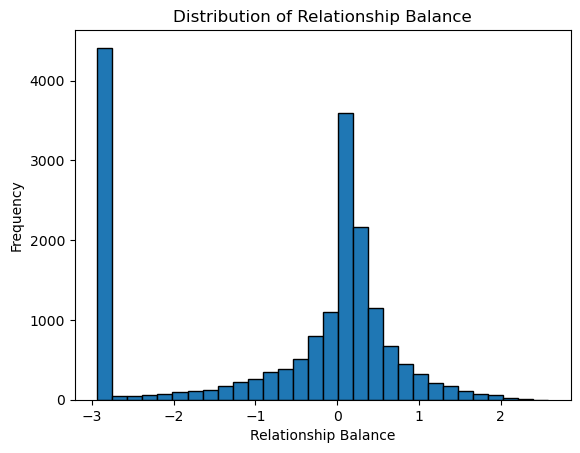

In [130]:
# plt.hist(df3["fe_amt_current_vs_avg"], bins=30, edgecolor='k')
plt.hist(np.log1p(df3["fe_amt_current_vs_avg"]), bins=30, edgecolor='k')
plt.title("Distribution of Relationship Balance")
plt.xlabel("Relationship Balance")
plt.ylabel("Frequency")
plt.show()

In [131]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 77 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   masked_bank_num                     17765 non-null  int64  
 1   masked_account_type                 17765 non-null  int64  
 2   masked_product_code                 17765 non-null  int64  
 3   number_of_owners                    17765 non-null  int64  
 4   total_deposit_amount                17765 non-null  float64
 5   item_amt                            17765 non-null  float64
 6   relationship_balance                17765 non-null  float64
 7   rdis                                17765 non-null  float64
 8   max_deposit_amount30d               17765 non-null  float64
 9   total_deposit_item_count            17765 non-null  float64
 10  prevtran1                           17765 non-null  float64
 11  prevtran2                           17765

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def l1_model(X_other, y_other, X_test, y_test, random_state, verbose=1):
    n_splits = 5
    this_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(solver='saga', penalty='l1', n_jobs=-1, random_state=random_state)

    param_grid = {
        'C': 1 / np.logspace(-2, 2, num=5)
    }

    pg = ParameterGrid(param_grid)
    scores = np.zeros((len(pg), n_splits))

    for i, params in enumerate(pg):
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other, y_other)):
            X_train = X_other.iloc[train_index, :]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index, :]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            y_val_pred = clf.predict(X_val)
            scores[i, j] = accuracy_score(y_val, y_val_pred)

    scores = np.mean(scores, axis=1)
    best_params = np.array(pg)[scores == np.max(scores)]

    # Retrain on last split's training set with best params (for reproducibility)
    clf.set_params(**best_params[0])
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, y_test_pred, best_params

In [133]:
from sklearn.model_selection import train_test_split

# 1. Separate features and target
X = df3.drop(columns=["return_target"])
y = df3["return_target"]

# Optional: if there are categorical features, encode them first
# If all features are already numeric, skip this step
# Example for one-hot encoding:
# X = pd.get_dummies(X, drop_first=True)

# 2. Split into "other" (train/val) and test
X_other, X_test, y_other, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Call the l1_model function
acc, y_test_pred, best_params = l1_model(X_other, y_other, X_test, y_test, random_state=42)

/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Accuracy: 0.6721
Precision: 0.5268
Recall: 0.1902
F1 Score: 0.2795


/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [134]:
print(np.mean(y_test_pred))

0.12074303405572756


In [136]:
np.mean(df3["return_target"])

np.float64(0.3344779059949339)

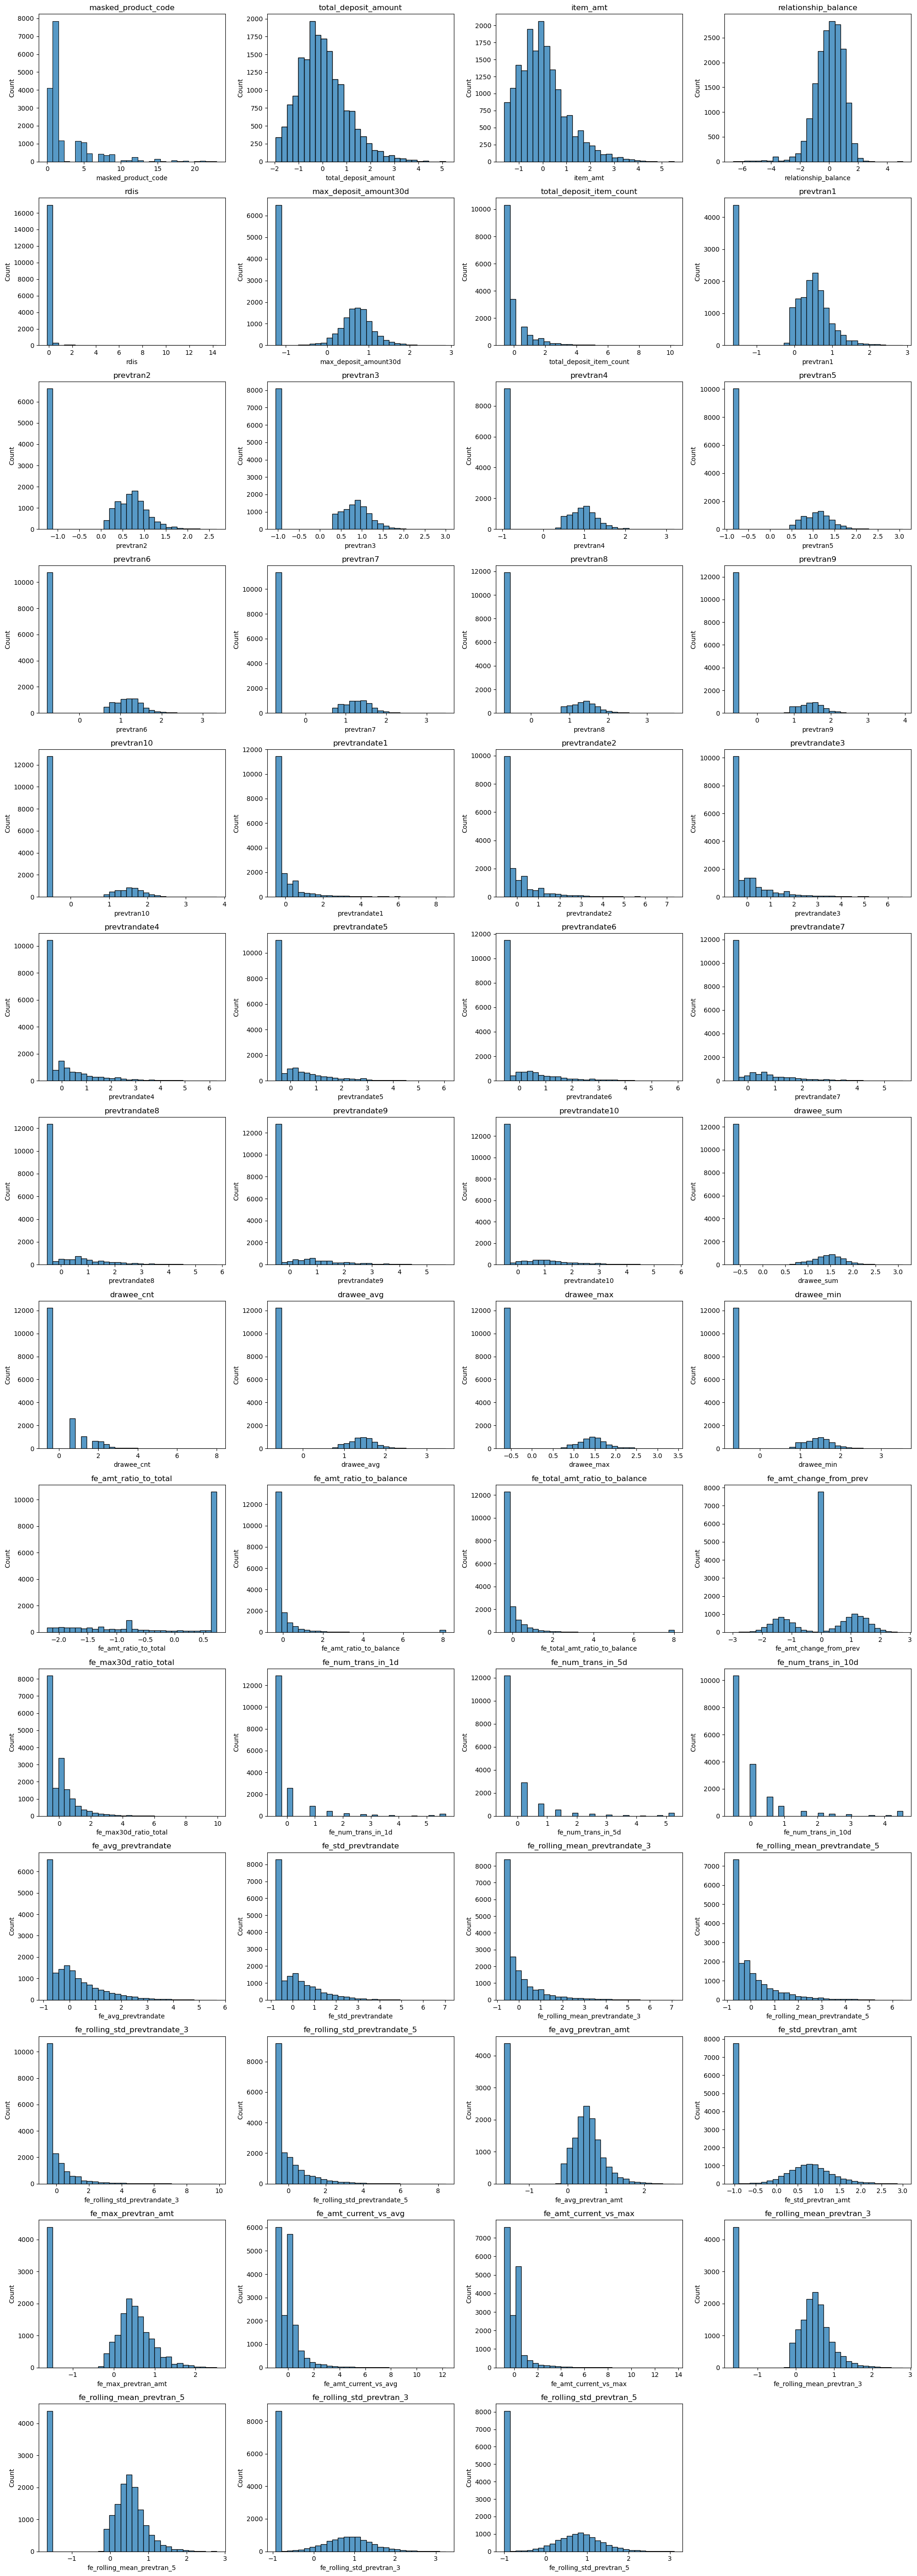

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Select continuous columns (excluding flags/categoricals)
continuous_cols = df3.select_dtypes(include=["float64", "int64"]).columns
# Optional: filter out binary/low-variance cols (e.g., < 10 unique values)
continuous_cols = [col for col in continuous_cols if df3[col].nunique() > 10]

# Step 2: Plot histograms
n_cols = 4
n_rows = int(np.ceil(len(continuous_cols) / n_cols))
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(continuous_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df3[col].dropna(), kde=False, bins=30)
    plt.title(col)
    plt.tight_layout()

plt.show()
